In [2]:
from pyspark.sql import SparkSession
import warnings
from pyspark.sql.functions import col
import pandas as pd

warnings.filterwarnings("ignore")

In [24]:
spark = SparkSession.builder \
    .appName("Read CSV with PySpark") \
    .getOrCreate()

csv_file_path = "DATASET_STORE\\UPDATE DATASET_1.csv"

df = spark.read.csv(csv_file_path, header=True, inferSchema=True)


In [25]:
df.show()

+-------------------+----------+------------+----+------------+------------+------------+------------+--------------------+--------------------+--------------------+---------------------------+------------------+------------------+------------------+-------------------------+-----------+-----------+-----------+-------------+------------+------------+------------+-------------+--------------------+--------------------+--------------------+---------------------------+-------------------+-------------------+-------------------+--------------------------+-------------------+-------------------+-------------------+--------------------------+--------------------+--------------------+--------------------+---------------------------+
|           datetime|  latitude|   longitude| mag|       SUN_x|       SUN_y|       SUN_z|distance_sun|MERCURY BARYCENTER_x|MERCURY BARYCENTER_y|MERCURY BARYCENTER_z|distance_mercury barycenter|VENUS BARYCENTER_x|VENUS BARYCENTER_y|VENUS BARYCENTER_z|distance_venus

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, TimeDistributed, Reshape
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('DATASET_STORE\\UPDATE DATASET_1.csv')

In [3]:

data = df[['latitude', 'longitude', 'SUN_x', 'SUN_y', 'SUN_z', 'distance_sun',
           'MERCURY BARYCENTER_x', 'MERCURY BARYCENTER_y', 'MERCURY BARYCENTER_z', 'distance_mercury barycenter',
           'VENUS BARYCENTER_x', 'VENUS BARYCENTER_y', 'VENUS BARYCENTER_z', 'distance_venus barycenter',
           'MOON_x', 'MOON_y', 'MOON_z', 'distance_moon', 'MARS_x', 'MARS_y', 'MARS_z', 'distance_mars',
           'JUPITER BARYCENTER_x', 'JUPITER BARYCENTER_y', 'JUPITER BARYCENTER_z', 'distance_jupiter barycenter',
           'SATURN BARYCENTER_x', 'SATURN BARYCENTER_y', 'SATURN BARYCENTER_z', 'distance_saturn barycenter',
           'URANUS BARYCENTER_x', 'URANUS BARYCENTER_y', 'URANUS BARYCENTER_z', 'distance_uranus barycenter',
           'NEPTUNE BARYCENTER_x', 'NEPTUNE BARYCENTER_y', 'NEPTUNE BARYCENTER_z', 'distance_neptune barycenter']]

data = data.values

scaler_features = MinMaxScaler()
scaler_targets = MinMaxScaler()

scaler_features.fit(data[:, :2])
scaler_targets.fit(data[:, :2])

data[:, :2] = scaler_features.transform(data[:, :2])

time_steps = 10  
num_features = data.shape[1]

# time steps and features
time_steps = 10 
num_features = data.shape[1]

sequences = []
targets = []
for i in range(len(data) - time_steps):
    sequences.append(data[i:i+time_steps])
    targets.append(data[i+time_steps, 0:2])  # Predict latitude and longitude

sequences = np.array(sequences)
targets = np.array(targets)

# Define a model
input_layer = Input(shape=(time_steps, num_features))

# Reshape input to channel dimension in Conv1D
reshaped_input = Reshape((time_steps, num_features, 1))(input_layer)

# CNN
conv1 = TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'))(reshaped_input)
pool1 = TimeDistributed(MaxPooling1D(pool_size=2))(conv1)
conv2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(pool1)
pool2 = TimeDistributed(MaxPooling1D(pool_size=2))(conv2)
flatten = TimeDistributed(Flatten())(pool2)

# LSTM
lstm_out = LSTM(units=50, return_sequences=False)(flatten)

# Dense
dense1 = Dense(units=64, activation='relu')(lstm_out)
output_layer = Dense(units=2, activation='linear')(dense1)  # Predict latitude and longitude

# Compile
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 39)]          0         
                                                                 
 reshape (Reshape)           (None, 10, 39, 1)         0         
                                                                 
 time_distributed (TimeDistr  (None, 10, 37, 32)       128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 18, 32)       0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 16, 64)       6208      
 tributed)                                                       
                                                             

In [4]:
# model.fit(sequences, targets, epochs=3, batch_size=64)

Epoch 1/3
15222/15222 [==============================] - 140s 9ms/step - loss: 0.0667
Epoch 2/3
15222/15222 [==============================] - 142s 9ms/step - loss: 0.0654
Epoch 3/3
15222/15222 [==============================] - 143s 9ms/step - loss: 0.0651


In [5]:
# model.save('ModelTraining/multimodel.h5')
from keras.models import load_model

model = load_model('ModelTraining/multimodel.h5')

In [6]:
predictions = model.predict(sequences)
predictions = scaler_targets.inverse_transform(predictions)
targets_original = scaler_targets.inverse_transform(targets)

30444/30444 [==============================] - 106s 3ms/step


In [8]:
import matplotlib.pyplot as plt

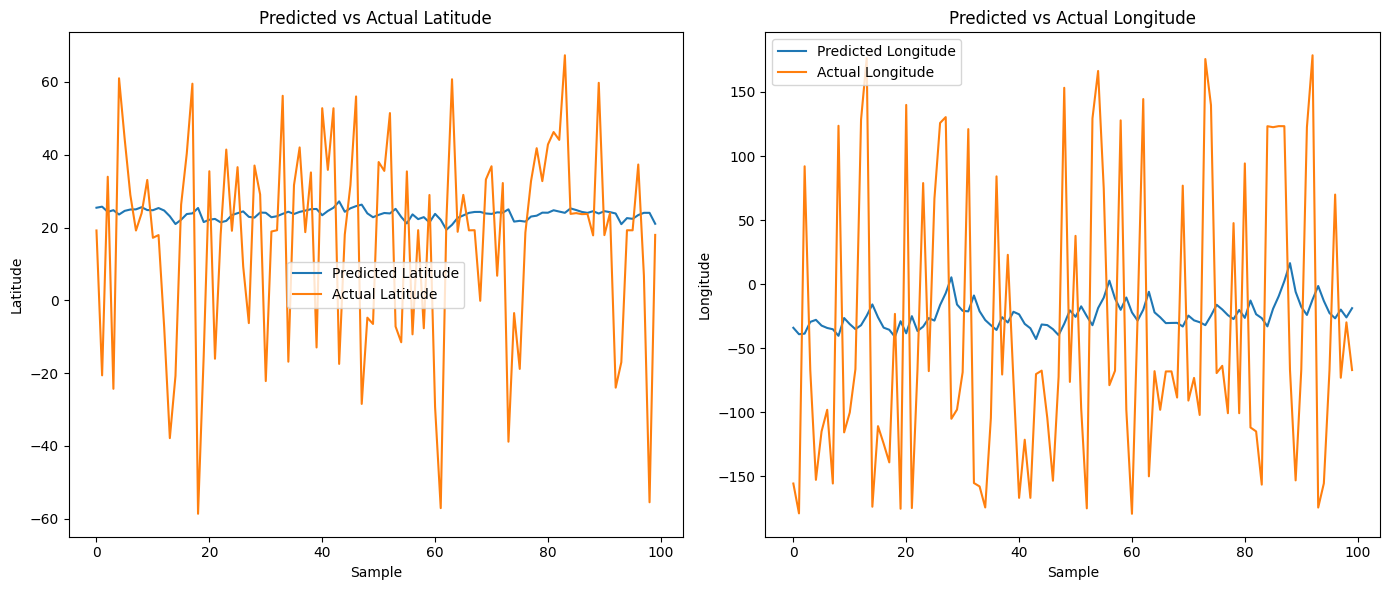

In [12]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(predictions[-100:, 0], label='Predicted Latitude')
plt.plot(targets_original[-100:, 0], label='Actual Latitude')
plt.title('Predicted vs Actual Latitude')
plt.xlabel('Sample')
plt.ylabel('Latitude')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(predictions[-100:, 1], label='Predicted Longitude')
plt.plot(targets_original[-100:, 1], label='Actual Longitude')
plt.title('Predicted vs Actual Longitude')
plt.xlabel('Sample')
plt.ylabel('Longitude')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
targets_original

array([[  18.945    , -107.252    ],
       [  33.903    , -116.4756667],
       [  33.1768333, -116.1035   ],
       ...,
       [   6.8279   ,  -72.984    ],
       [ -55.5229   ,  -29.7614   ],
       [  17.9695   ,  -66.98     ]])

In [8]:
predictions

array([[ 35.1493  , -56.154724],
       [ 34.106617, -53.90433 ],
       [ 34.798397, -58.01238 ],
       ...,
       [ 24.041246, -19.818869],
       [ 24.033812, -25.881504],
       [ 21.036432, -18.713049]], dtype=float32)

In [10]:
da = pd.DataFrame(data)
da

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.689463,0.167663,3.22,-1.002941,-0.017215,-0.007477,1.003116,-0.716299,0.131346,0.042098,...,0.731936,10.426030,-3.292888,17.154354,7.545797,19.027717,-29.856665,-8.799310,-2.883931,31.259644
1,0.689657,0.167480,2.74,-1.002941,-0.017215,-0.007477,1.003116,-0.716299,0.131346,0.042098,...,0.731936,10.426030,-3.292888,17.154354,7.545797,19.027717,-29.856665,-8.799310,-2.883931,31.259644
2,0.693390,0.667839,5.68,-1.002941,-0.017215,-0.007477,1.003116,-0.716299,0.131346,0.042098,...,0.731936,10.426030,-3.292888,17.154354,7.545797,19.027717,-29.856665,-8.799310,-2.883931,31.259644
3,0.688635,0.178254,2.82,-1.002189,-0.032929,-0.014291,1.002832,-0.735692,0.137243,0.048918,...,0.723036,10.423991,-3.296069,17.138019,7.538767,19.010754,-29.854976,-8.817760,-2.891888,31.263965
4,0.685409,0.177690,2.53,-1.002189,-0.032929,-0.014291,1.002832,-0.735692,0.137243,0.048918,...,0.723036,10.423991,-3.296069,17.138019,7.538767,19.010754,-29.854976,-8.817760,-2.891888,31.263965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974209,0.603329,0.313661,3.39,0.860399,-0.446617,-0.193605,0.988552,1.121497,-0.731837,-0.373031,...,-1.845292,10.701497,12.975644,13.734910,5.846028,19.778553,30.711105,-1.684553,-1.443433,30.791122
974210,0.708589,0.694271,4.40,0.860399,-0.446617,-0.193605,0.988552,1.121497,-0.731837,-0.373031,...,-1.845292,10.701497,12.975644,13.734910,5.846028,19.778553,30.711105,-1.684553,-1.443433,30.791122
974211,0.531116,0.297266,4.50,0.860399,-0.446617,-0.193605,0.988552,1.121497,-0.731837,-0.373031,...,-1.845292,10.701497,12.975644,13.734910,5.846028,19.778553,30.711105,-1.684553,-1.443433,30.791122
974212,0.168206,0.417329,4.90,0.869012,-0.432753,-0.187595,0.988761,1.146135,-0.700266,-0.359223,...,-1.837355,10.703591,12.981130,13.750822,5.852979,19.795257,30.719864,-1.667762,-1.436229,30.798607
